In [1]:
import pandas as pd
import numpy as np
import math
import re
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Bidirectional
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# df = pd.read_csv('/content/drive/MyDrive/Soft Computing/Project/updated_dataset.csv')


#without removing stop words and lemmatization
df = pd.read_csv('/content/drive/MyDrive/Soft Computing/Project/dataset_v1.csv')

In [4]:
df.head()

,Unnamed: 0,review,sentiment,target
0,24418,Ripping this movie apart is like shooting fish...,negative,0
1,38386,Unfortunately this is not one of those movies ...,negative,0
2,3089,This film shows up on the premium cable channe...,positive,1
3,15998,Seriously - avoid this movie at any cost. I ju...,negative,0
4,22444,This is simply the funniest movie I've seen in...,positive,1


## Vectorization

In [5]:
dataset = df
unique_label = np.unique(df["target"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['review'].values, pd.get_dummies(dataset['target']).values, test_size=0.30)

MAX_NB_WORDS = 124335
MAX_SEQUENCE_LENGTH = 4000
EMBEDDING_DIM = 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index
print("found ", len(word_index), " unique tokens")

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
pad_test = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_train.shape)

print(pad_train.shape,y_train.shape)
print(pad_test.shape,y_test.shape)

found  124335  unique tokens
Shape of data tensor: (35000, 4000)
(35000, 4000) (35000, 2)
(15000, 4000) (15000, 2)


# Model CNN

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# define model
model = Sequential()

model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=pad_train.shape[1]))

model.add(Conv1D(filters = 50, kernel_size = 3))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(filters = 40, kernel_size = 3))
model.add(MaxPooling1D(pool_size = 2))

model.add(Conv1D(filters=30, kernel_size=3))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(10, activation='tanh'))
model.add(Dense(2, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model.summary()

epochs = 50
batch_size = 128

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4000, 250)         31083750  
_________________________________________________________________
conv1d (Conv1D)              (None, 3998, 50)          37550     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1999, 50)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1997, 40)          6040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 998, 40)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 996, 30)           3630      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 498, 30)           0

In [7]:
history = model.fit(pad_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(pad_test, y_test))

Epoch 1/50
274/274 [==============================] - 105s 262ms/step - loss: 0.4128 - accuracy: 0.7941 - val_loss: 0.2787 - val_accuracy: 0.8878
Epoch 2/50
274/274 [==============================] - 69s 253ms/step - loss: 0.1586 - accuracy: 0.9462 - val_loss: 0.3347 - val_accuracy: 0.8697
Epoch 3/50
274/274 [==============================] - 69s 253ms/step - loss: 0.0580 - accuracy: 0.9855 - val_loss: 0.3255 - val_accuracy: 0.8881
Epoch 4/50
274/274 [==============================] - 69s 253ms/step - loss: 0.0244 - accuracy: 0.9948 - val_loss: 0.4889 - val_accuracy: 0.8668
Epoch 5/50
274/274 [==============================] - 69s 253ms/step - loss: 0.0162 - accuracy: 0.9965 - val_loss: 0.4364 - val_accuracy: 0.8862
Epoch 6/50
274/274 [==============================] - 69s 253ms/step - loss: 0.0177 - accuracy: 0.9954 - val_loss: 0.4821 - val_accuracy: 0.8843
Epoch 7/50
274/274 [==============================] - 69s 253ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.5880 - val_a

In [8]:
evaluation = model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

469/469 [==============================] - 11s 22ms/step - loss: 0.7543 - accuracy: 0.8827
Accuracy is :  88.27333450317383


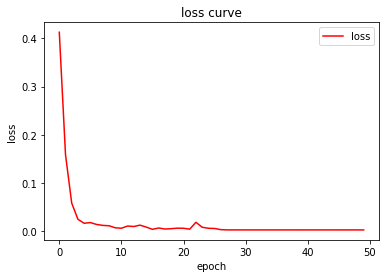

In [9]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], color='r')
# pyplot.plot(history.history['val_loss'], color='b')
pyplot.title('loss curve')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show()

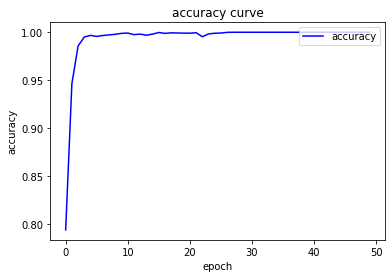

In [10]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()

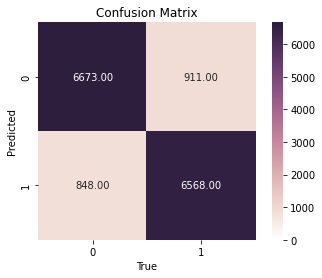

In [11]:
y_pred = model.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_y_pred)):
        conf_arr[new_y_pred[i]][new_y_test[i]] += 1

df_cm = pd.DataFrame(conf_arr, index = unique_label, columns = unique_label)



fig = plt.figure()
plt.clf()

ax = fig.add_subplot()
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)
res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [12]:
print(classification_report(new_y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      7521
           1       0.89      0.88      0.88      7479

    accuracy                           0.88     15000
   macro avg       0.88      0.88      0.88     15000
weighted avg       0.88      0.88      0.88     15000



In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print('Pricision = ',precision)
print('F1_score = ',f1_score)
print('Recall = ',recall)

Pricision =  88.56526429341963
F1_score =  88.19066800939913
Recall =  87.81922716940768


In [14]:
model.save('/content/drive/MyDrive/Soft Computing/Project/saved_info/CNN/v5')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soft Computing/Project/saved_info/CNN/v5/assets


In [15]:
import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/Soft Computing/Project/saved_info/CNN/v5')

In [16]:
evaluation = loaded_model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

469/469 [==============================] - 11s 23ms/step - loss: 0.7543 - accuracy: 0.8827
Accuracy is :  88.27333450317383


In [17]:
np.save('/content/drive/MyDrive/Soft Computing/Project/saved_info/CNN/v5/history.npy',history.history)

In [18]:
h=np.load('/content/drive/MyDrive/Soft Computing/Project/saved_info/CNN/v5/history.npy',allow_pickle='TRUE').item()


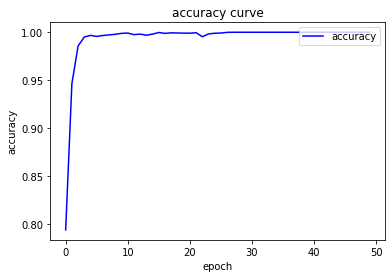

In [19]:
from matplotlib import pyplot

pyplot.plot(h['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()